## Simulation based reliability method

In [1]:
# Import auxiliary libraries for demonstration

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

plt.rcParams[ "figure.figsize" ] = [ 5, 4 ]

plt.rcParams[ "figure.dpi" ] = 80
plt.rcParams[ "font.family" ] = "Times New Roman"
plt.rcParams[ "font.size" ] = '14'

### Subset simulation

The subset simulation proposed by Au and Beck is used to determine the small failure probability in high dimensional space. The basic idea for subset simulation is to express the failure probability as a series of intermediate probability,

$$
p_f = P(E) = P(E_m) = P(E_m|E_{m-1})P(E_{m-1}|E_{m-2}) \dots P(E_1)
$$

where $P(E_i)$ denotes the probability of event $E_i$; $P(E_{m-1}|E_{m-2})$ denotes the conditional probability of event $E_{m-1}$ given $E_{m-2}$. 

The intermediate event $E_{m-1}$ can be considered the $p_0$-quantile of the previous event $E_{m-2}$, where $p_0$ is a predefined probability level. Usually, the optimal value for the probability level is $p_0=0.1-0.3$. After the intermediate event $E_{m-1}$ is obtained by the $p_0$-quantile of the previous event $E_{m-2}$, it can be consider as the initial sampling points for MCMC chains to determine the next intermediate event $E_{m}$.

Function `subsetSimulation` implements the subset simulation algorithm.

Reference: 

* Au, S.K. and Beck, J.L., 2001. Estimation of small failure probabilities in high dimensions by subset simulation. Probabilistic engineering mechanics, 16(4), pp.263-277.

#### Function help

In [2]:
from ffpack.rrm import subsetSimulation
help( subsetSimulation )

Help on function subsetSimulation in module ffpack.rrm.simulationBasedReliabilityMethod:

subsetSimulation(dim, g, distObjs, corrMat, numSamples, maxSubsets, probLevel=0.1, quadDeg=99, quadRange=8, randomSeed=None)
    Second order reliability method based on Breitung algorithm.
    
    Parameters
    ----------
    dim: integer
        Space dimension ( number of random variables ).
    g: function
        Limit state function. It will be called like g( [ x1, x2, ... ] ).
    distObjs: array_like of distributions
        Marginal distribution objects. It should be the freezed distribution 
        objects with pdf, cdf, ppf. We recommend to use scipy.stats functions.
    corrMat: 2d matrix
        Correlation matrix of the marginal distributions.
    numSamples: integer
        Number of samples in each subset.
    maxSubsets: scalar
        Maximum number of subsets used to compute the failure probability.
    probLevel: scalar, optional
        Probability level for intermediate su

#### Example with linear LSF

In [3]:
# Define the dimension for the FORM problem
dim = 2

# Define the limit state function (LSF) g
g = lambda X: -np.sum( X ) / np.sqrt( dim ) + 3.0

# Marginal distributions and correlation Matrix of the random variables
distObjs = [ stats.norm(), stats.norm() ]
corrMat = np.eye( dim )
numSamples, maxSubsets = 3000, 10

pf, allLsfValues, allUSamples, allXSamples = \
        subsetSimulation( dim, g, distObjs, corrMat, numSamples, 
                          maxSubsets, randomSeed=2023 )

In [4]:
print( "Failure probability: " )
print( pf )

Failure probability: 
0.0009706666666666669


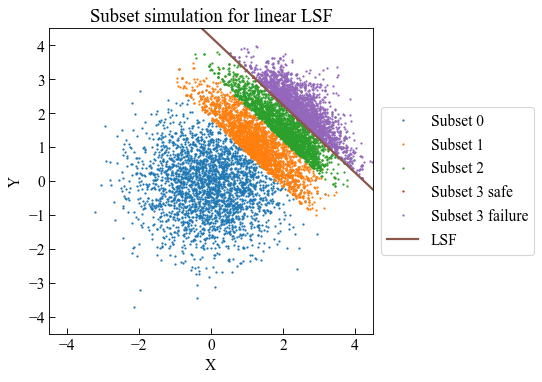

In [5]:
fig, ax = plt.subplots( figsize=( 7, 5 ) )

# Plot samples in each subset
for idx, uSamples in enumerate( allUSamples ):
    if idx != len( allUSamples ) - 1:
        ax.plot( uSamples[ :, 0], uSamples[ :, 1 ], 
                 ".", markersize=2, label='Subset %d' % idx )
    else:
        # For the last subset, we plot the non-failure points and failure points
        fidx = np.searchsorted( allLsfValues[ idx ], 0.0, side='right' )
        ax.plot( uSamples[ fidx: , 0], uSamples[ fidx: , 1 ], 
                 ".", markersize=2, label='Subset %d safe' % idx )
        ax.plot( uSamples[ : fidx, 0], uSamples[ : fidx, 1 ], 
                 ".", markersize=2, label='Subset %d failure' % idx )

# Plot limit state function
gx = np.linspace( -4.5, 4.5, 200)
gy = [ 3 * np.sqrt( dim ) - x for x in gx ]
ax.plot( gx, gy, linewidth=2, label='LSF' )
    
ax.tick_params( axis='x', direction="in", length=5 )
ax.tick_params( axis='y', direction="in", length=5 )
ax.set_ylabel( "Y" )
ax.set_xlabel( "X" )
ax.set_title( "Subset simulation for linear LSF" )
ax.set_xlim( [ -4.5, 4.5 ] )
ax.set_ylim( [ -4.5, 4.5 ] )
ax.legend( loc='center left', bbox_to_anchor= (1, 0.5 ) )

plt.tight_layout()
plt.show()

#### Example with nonlinear LSF

In [6]:
# Define the dimension for the FORM problem
dim = 2

# Define the limit state function (LSF) g
g = lambda X: -( X[0] * X[1] ) + 6

# Marginal distributions and correlation Matrix of the random variables
distObjs = [ stats.norm(), stats.norm() ]
corrMat = np.eye( dim )
numSamples, maxSubsets = 3000, 10

pf, allLsfValues, allUSamples, allXSamples = \
        subsetSimulation( dim, g, distObjs, corrMat, numSamples, 
                          maxSubsets, randomSeed=2023 )

In [7]:
print( "Failure probability: " )
print( pf )

Failure probability: 
0.0004250000000000001


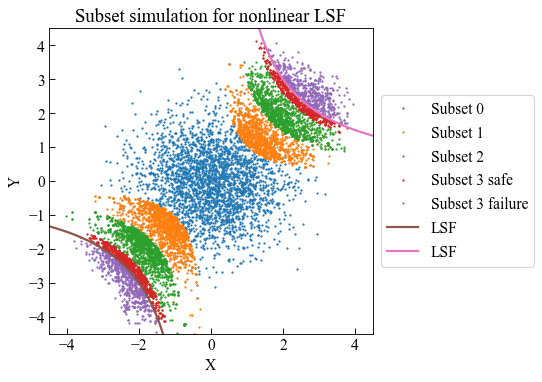

In [8]:
fig, ax = plt.subplots( figsize=( 7, 5 ) )

# Plot samples in each subset
for idx, uSamples in enumerate( allUSamples ):
    if idx != len( allUSamples ) - 1:
        ax.plot( uSamples[ :, 0], uSamples[ :, 1 ], 
                 ".", markersize=2, label='Subset %d' % idx )
    else:
        # For the last subset, we plot the non-failure points and failure points
        fidx = np.searchsorted( allLsfValues[ idx ], 0.0, side='right' )
        ax.plot( uSamples[ fidx: , 0], uSamples[ fidx: , 1 ], 
                 ".", markersize=2, label='Subset %d safe' % idx )
        ax.plot( uSamples[ : fidx, 0], uSamples[ : fidx, 1 ], 
                 ".", markersize=2, label='Subset %d failure' % idx )
        
# Plot limit state function
gx = np.linspace( -4.5, 4.5, 200)
gy = [ 6.0 / x for x in gx ]
ax.plot( gx[ : 100], gy[ : 100], linewidth=2, label='LSF' )
ax.plot( gx[ 100: ], gy[ 100: ], linewidth=2, label='LSF' )
    
ax.tick_params( axis='x', direction="in", length=5 )
ax.tick_params( axis='y', direction="in", length=5 )
ax.set_ylabel( "Y" )
ax.set_xlabel( "X" )
ax.set_title( "Subset simulation for nonlinear LSF" )
ax.set_xlim( [ -4.5, 4.5 ] )
ax.set_ylim( [ -4.5, 4.5 ] )
ax.legend( loc='center left', bbox_to_anchor= (1, 0.5 ) )

plt.tight_layout()
plt.show()